In [119]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [120]:
import scipy
from scipy.stats import norm as norm
import scipy.integrate as integrate
import pandas as pd
from scipy.optimize import curve_fit
import time

In [121]:
# norm.pdf takes parameters x, mu, and then sigma

# here x remains constant, but mu and sigma change
mu = np.linspace(-5,5,200)
x_values = norm.pdf(0,mu,1)

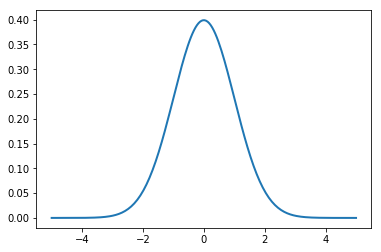

In [122]:
plt.plot(mu,x_values, linewidth = 2)

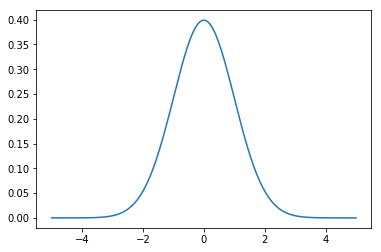

In [123]:
# now keep mu and sigma constant, but vary x 
plt.plot(mu, norm.pdf(mu, 0, 1))

The two graphs above are the same, so then it makes sense that integrating over mu or integrating over x yeilds the same result, so then we get that the CDF is some form of an erf function. However, I'm not sure that that is the result we want, since given a single drawn instability time, we don't know what the underlying distribution is, because we only have a distribution on sigma, and no information on mu.
So prehaps we don't want to just calculate an integration over mu.


Going back to the equation:

$\int_{0}^{\inf} \exp \bigg(\frac{(t' - \mu)^2}{2 \sigma^2}\bigg) \exp \bigg(\frac{(t - \mu)^2}{2 \sigma^2}\bigg) d\mu$

Ignore normalization constants for now

In [124]:
#lets empirically determine this 
data = pd.read_csv("../csvs/deltatimes.csv", index_col=0)
data.head()

,runstring,t,t_shadow
0,0000000.bin,1.235644e+07,8.315081e+07
1,0000001.bin,1.348749e+05,2.133072e+05
2,0000002.bin,1.276381e+04,9.321519e+03
3,0000003.bin,1.000000e+09,1.000000e+09
4,0000004.bin,8.791888e+01,8.791888e+01


In [125]:
sample_t = np.log10(data.loc[1]["t"]) # I chose a value that would make it pass our cuts

Plot above integrand with a const sigma of 0.45, and varying mu ( since thats what we don't know). The const sigma doesn't really matter for this

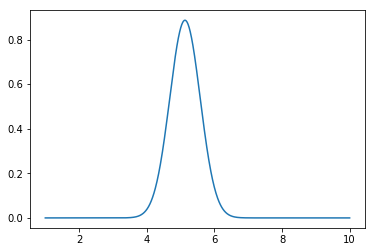

In [126]:
mu_range = np.linspace(4, 7, 300) # range by our cuts
x_range = np.linspace(1, 10, 900)

sigma_const = 0.45

# assuming mu is the same as sample_t, plot with const mu for now
# this is with only one guassian, not with a multiplication of two
plt.plot(x_range, norm.pdf(x_range, sample_t, sigma_const))

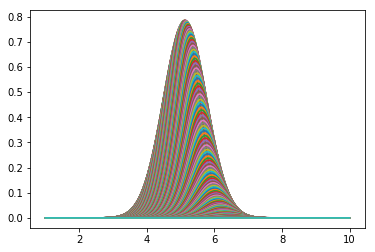

In [127]:
fig, ax = plt.subplots()

for index, mu in enumerate(mu_range):
    # distribution of drawing t, given sigma and a mu value
    dist_of_drawing_t = norm.pdf(x_range, mu, sigma_const)
    # distribution of drawing the drawn value of t given mu (Note, this peaks when t= mu)
    prob_of_current_t = norm.pdf(sample_t, mu, sigma_const)
    ax.plot(x_range, dist_of_drawing_t * prob_of_current_t)

The above is what we'd want to sum over, to integrate over the weighted ranges of mu by 

In [128]:
cumulative_y = np.zeros(x_range.shape[0])

for index, mu in enumerate(mu_range):
    # distribution of drawing t, given sigma and a mu value
    dist_of_drawing_t = norm.pdf(x_range, mu, sigma_const)
    # distribution of drawing the drawn value of t given mu (Note, this peaks when t= mu)
    prob_of_current_t = norm.pdf(sample_t, mu, sigma_const)
    cumulative_y += (dist_of_drawing_t * prob_of_current_t)   

In [129]:
# normalize this distribution

result = integrate.trapz(cumulative_y, x_range)
cumulative_y = cumulative_y/result


https://en.wikipedia.org/wiki/Gaussian_function  States that the
convolution of two guassians (which I believe is more akin to what we're doing here) is also a gaussian, with the following variance

$\sigma^2 = \sigma_1^2 + \sigma_2^2$

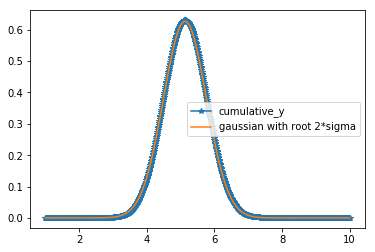

In [130]:
fig , ax = plt.subplots()    
ax.plot(x_range, cumulative_y, label = "cumulative_y", marker = "*") # yields another gaussian

# the factor of sqrt2 works since we have the same sigma for the two distributions
ax.plot(x_range, norm.pdf(x_range, sample_t, sigma_const*np.sqrt(2)), label = "gaussian with root 2*sigma")
plt.legend()

The two graphs above overlap, showing that our assumtion of integrating over mu with the weighted gaussian is correct - > its equivalent to convolving it

We've now have shown that integrating over mu over the product of the two gaussians gives us another gaussian, how about integrating over a guassian distribution for sigma? (We should expect a lapacian distribution empirically)

We'll assume the parameters for the sigma Gaussian distribution to be $\mu = 0.455$, and $\sigma$ = 0.145 (the actual values shouldn't matter here)

0.020453414079905797


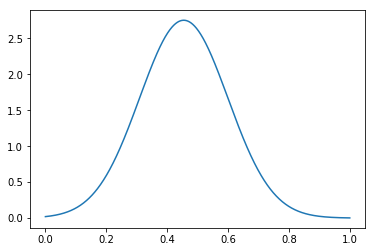

In [131]:
sigma_const = 0.145
mu_const = 0.455

sigma_range = np.linspace(0.001,1, 1000)

sigma_gaussian = norm.pdf(sigma_range, mu_const, sigma_const)
plt.plot(sigma_range, sigma_gaussian)
print(sigma_gaussian[0]) # notice that this is not 0. 

Since we determined that integrating over mu gives a gaussian peaked at our drawn value of t, we should be able to sum over gaussians with varying sigma's weighted appropriately centered at the same point

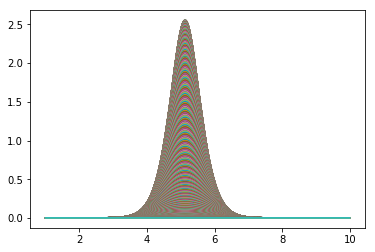

In [132]:
fig, ax = plt.subplots()
x_range = np.linspace(1, 10, 900)


for index, sigma in enumerate(sigma_range):
    # distribution of drawing t, given sigma and a mu value
    dist_of_drawing_t = norm.pdf(x_range, sample_t, sigma)
    # distribution of drawing the drawn value of sigma 
    prob_of_current_sigma = norm.pdf(sigma, mu_const, sigma_const)
    ax.plot(x_range, dist_of_drawing_t * prob_of_current_sigma)

In [133]:
#sum over this distribution

cumulative_y = np.zeros(x_range.shape[0])

for index, sigma in enumerate(sigma_range):
    # distribution of drawing t, given sigma and a mu value
    dist_of_drawing_t = norm.pdf(x_range, sample_t, sigma)
    # distribution of drawing the drawn value of sigma 
    prob_of_current_sigma = norm.pdf(sigma, sigma_const, mu_const)
    cumulative_y += dist_of_drawing_t * prob_of_current_sigma

In [134]:
# normalize this distribution

result = integrate.trapz(cumulative_y, x_range)
cumulative_y = cumulative_y/result

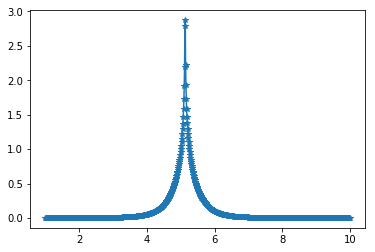

In [135]:
fig , ax = plt.subplots()    
ax.plot(x_range, cumulative_y, label = "cumulative_y", marker = "*") # yields another gaussian


In [136]:
def laplace_fit(data, mean, spread):
    #data is your data
    #mean spread are the params you try to fit to the data
    return np.exp(-np.abs(data-mean)/spread)/2./spread

[5.13043278 0.24882663]
[0.00154473 0.00218539]
5.129931081706897


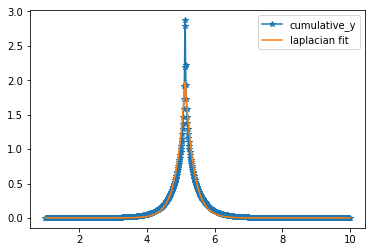

In [137]:
popt, pcov = curve_fit(laplace_fit, x_range, cumulative_y)
print(popt)
perr = np.sqrt(np.diag(pcov))
print(perr)
print(sample_t) # notice sample t is very similar to popt loc parameter

fig , ax = plt.subplots()    
ax.plot(x_range, cumulative_y, label = "cumulative_y", marker = "*") # yields another gaussian
ax.plot(x_range, laplace_fit(x_range, *popt), label = "laplacian fit")
plt.legend()

Running the above experiment with varying values still yeilds a laplacian of some sort

Thus doing the same weighted integral over sigma yields a laplacian.
Can we determine the relation between our intial sigma parameters and the resulting laplacian spread parameter? (they both have the same loc parameter)

Again we notice the same behavior where the laplacian distribution doesn't entirely match the peak


Start with varying sigma_const and mu_const values, and see if you can determine a relationship between it and the final b value

In [79]:
sigma_const = np.linspace(0.1, 0.2, 21)
mu_const = np.linspace(0.4, 0.6, 41)

sigma_range = np.linspace(0.001,1, 1000)
x_range = np.linspace(1, 10, 900)

b_values = np.zeros((sigma_const.shape[0], mu_const.shape[0]))
# iterate over differen combos of first sigma, and then mu

start = time.time()

for ind1, sigma_sigma in enumerate(sigma_const):
    for ind2, sigma_mu in enumerate(mu_const):
        
        sigma_gaussian = norm.pdf(sigma_range, sigma_mu, sigma_sigma)

        #sum over this distribution
        cumulative_y = np.zeros(x_range.shape[0])

        for index, sigma in enumerate(sigma_range):
            # distribution of drawing t, given sigma and a mu value
            dist_of_drawing_t = norm.pdf(x_range, sample_t, sigma)
            # distribution of drawing the drawn value of sigma 
            prob_of_current_sigma = norm.pdf(sigma, sigma_mu, sigma_sigma)
            cumulative_y += dist_of_drawing_t * prob_of_current_sigma


        # normalize this distribution
        result = integrate.trapz(cumulative_y, x_range)
        cumulative_y = cumulative_y/result

        popt, pcov = curve_fit(laplace_fit, x_range, cumulative_y)
        # print(popt)
        # perr = np.sqrt(np.diag(pcov))
        # print(perr)
        b_values[ind1, ind2] = popt[1]
    print(ind1)
end = time.time()
print(end-start, "sec")

0
1
2
3
4
5
6
7
8


/home/naireen/anaconda2/envs/CSC401/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in exp
/home/naireen/anaconda2/envs/CSC401/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in true_divide


9
10
11
12
13
14
15
16
17
18
19
20
225.5770161151886 sec


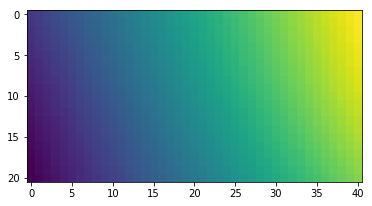

In [80]:
plt.imshow(b_values)

1.0172578288559235 -0.06676540984422641 0.9999805645262859 1.2625245003091738e-87 0.001015588164518511


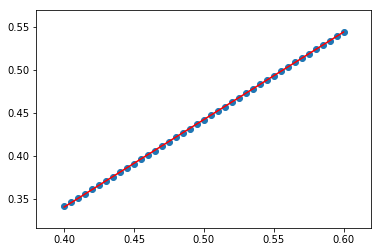

In [118]:
# is there a linear relation between sigma_mu and b when sigma_sigma is fixed?
b_values_slice = b_values[20, :]

fig , ax = plt.subplots()    

ax.scatter(mu_const, b_values_slice, label = "observed b")

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(mu_const, b_values_slice)
print(slope, intercept, r_value, p_value, std_err)

ax.plot(mu_const, intercept + slope*mu_const, 'r', label='fitted line')

# looks like there is a linear relation, is it possible due to the small range we're looking at?
# the slope seems to vary when looking at differen fixed values of sigma, it must influence it somehow then, 
# but the fluctuations are small

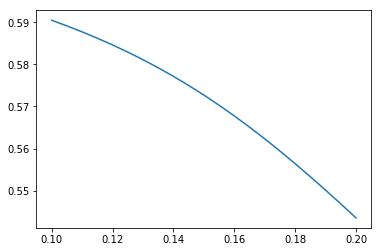

In [87]:
# is there a linear relation between sigma_sigma and b when sigma_mu is fixed?
plt.plot(sigma_const, b_values[:,-1])
# no, this doesn't look linear, possibly quadratic?